In [1]:
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk, surface

abtem.config.set({"local_diagnostics.progress_bar": False});

(getting_started:user_guide:multislice)=
# Multislice simulations

In the [introduction to potentials](getting_started:user_guide:potentials), we described how to integrate the potential into a series of thin slices $V_n$ along the optical axis (see {eq}`eq:potentials:slice`). Given a wave function representing fast electrons at the entrance of the $n$'th slice, $\phi_n(\vec{r})$, the wave function at exit of that slice may be written as

$$
    \phi_{n + 1}(\vec{r}) = p(\vec{r}) * \left[t_n(\vec{r}) \phi_n(\vec{r}) \right]
$$ (eq:getting_started:user_guide:multislice:multislice)

where 

$$
    p(\vec{r}) = \frac{1}{i \lambda \Delta z}\exp\left[\frac{i\pi}{\lambda \Delta z} r^2 \right]
$$

is the Fresnel free space operator for propagation by $\Delta z$ along the $z$-axis, $*$ is the convolution operator and 

$$
    t(\vec{r}) = \exp\left[i\sigma V_n(\vec{r})\right] 
$$

is the transmission function which applies a phase shift proportional to the magnitude of the potential, the proportionality constant, $\sigma$, is called the interaction constant. Using the Fourier convolution theorem, we can write Eq. {eq}`eq:getting_started:user_guide:multislice:multislice` as

$$
    \phi_{n+1}(\vec{r}) = \mathcal{F}^{-1} \left\{P(\vec{k}) \ \mathcal{F}\left[t(\vec{r}) \phi_n(\vec{r})\right] \right\}  := \mathcal{M}_n \phi_n(\vec{r}) \quad ,
$$

where 

$$
    P(\vec{k}) = \exp(-i \pi \lambda k^2 \Delta z)
$$

is the Fresnel free space propagator in Fourier space and $\mathcal{F}$ and $\mathcal{F}^{-1}$ is the Fourier transform and its inverse, respectively.

For brevity we have defined a multislice operator, $\mathcal{M}_n$, acting on a wave function to step it forward through the $n$'th slice. Thus given an initial wave function $\phi_0$, we can obtain the exit wave function for a potential with slice indices $n=0,1,\ldots N$ by sequentially applying these operators

$$
    \phi_{exit}(\vec{r}) := \phi_{N}(\vec{r}) = \mathcal{M}_N \mathcal{M}_{N-1} \ldots \mathcal{M}_{0} \phi_0(\vec{r}) \quad .
$$


```{warning}
Phonon scattering is not included in the following, inclusions of phonons is important. Hence the following results may not correspond to experiment.
```

## Multislice simulations with plane waves

Below we create a `Potential` representing gold in the $\left<100\right>$ zone axis and use a `PlaneWave` as the initial wave function.

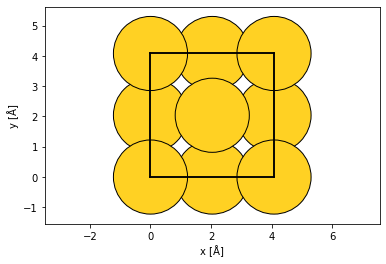

In [2]:
atoms = bulk("Au", cubic=True) * (1, 1, 35)

abtem.show_atoms(atoms, show_periodic=True, scale=0.9);

In [3]:
potential = abtem.Potential(atoms, slice_thickness=1, sampling=0.05)

plane_wave = abtem.PlaneWave(energy=200e3)

We create a task graph for running the multislice algorithm by calling `multislice` producing an exit wave function.

In [4]:
exit_wave = plane_wave.multislice(potential)

To execute the task graph, we call `compute`.

In [5]:
exit_wave.compute();

```{note}
Notice that we did not provide the sampling or extent of the wave function above, instead the wave function adopted the grid of the potential. A `GridUndefinedError` will be thrown if the grid is not defined for both the wave function and potential.
```

We can show the intensity of the resulting exit wave function.

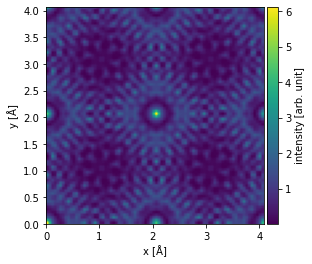

In [6]:
exit_wave.intensity().show(cbar=True);

In HRTEM experiments, the wave function have to be magnified by an objective lens which introduces aberrations and cuts off large scattering angles. See more in our introduction to the contrast transfer function.

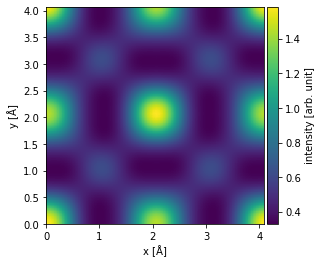

In [7]:
exit_wave.apply_ctf(defocus=-50, semiangle_cutoff=20).intensity().show(cbar=True);

### Electron diffraction patterns

Below we obtain the `DiffractionPatterns` simulating a [selected area diffraction (SAD)](https://en.wikipedia.org/wiki/Selected_area_diffraction) experiment. We use `block_direct=True` to block the direct beam. The direct beam typically has a much higher intensity than the scattered beams, thus it is typically not possible to show the direct spot on the same scale as the scattered spots. 

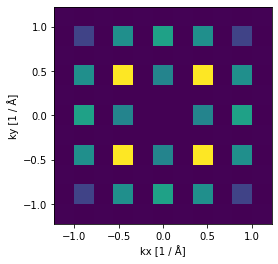

In [8]:
diffraction_patterns = exit_wave.diffraction_patterns(block_direct=True, max_angle=30, parity="odd")
diffraction_patterns.show();

The diffraction spots looks like squares. This is because the incoming wave function is a periodic and effectively infinite plane wave, hence the diffraction spots are points with no size. However, we are discretizing the wave function on a square grid (i.e. pixels), hence the spots can only be as small as single pixels. In real SAD experiments, the spot size is fundamentally broadened due to the finite extent of the crystal as well experimental factors.

*abTEM* provides the `plot_diffraction_pattern` function as an alternative for visualizing SAD patterns, producing a visualization that corresponds closer with typical textbook illustrations. The function allows overlaying the indexed diffraction spots. The cell edges of the conventional unit cell have to be provided in order to index the pattern.

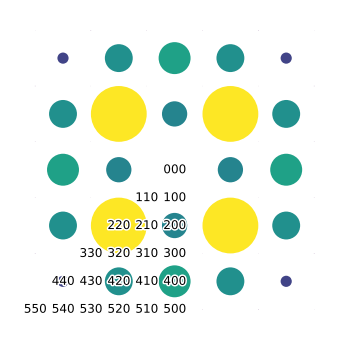

In [9]:
from abtem.visualize.mpl import plot_diffraction_pattern

plot_diffraction_pattern(
    diffraction_patterns, cell=4.08, spot_scale=2,
);

It is also possible to obtain a table of the intensity values of the indexed diffraction spots.

In [10]:
from abtem.measurements.indexing import tabulate_diffraction_pattern

table = tabulate_diffraction_pattern(
    diffraction_patterns,
    cell=4.08,
    normalize=True,
    return_data_frame=True,
    spot_threshold=0.001,
)
table

,200,220,310,330,400,420,440,510,530,550
0,0.452802,1.0,0.004454,0.004658,0.572662,0.499753,0.20015,0.006123,0.007601,0.004059


We see that all the spots up to $(200)$ are extinguished, as is expected for a FCC crystal in the $\left<100\right>$ zone axis. It may be slightly more surprising that $(220)$ spots have a higher intensity than the $(200)$ spots; this is due to dynamical scattering.

## Thickness series

*abTEM* allows us to obtain the wave function at intermediate steps of the multislice algorithm, thus allowing us to see how the wave function evolves as it passes through the potential. To create such a *thickness series* we set the `exit_planes` keyword, this may be given as a tuple of the slice indices, $n$, to return, or just a single integer to indicate the step between slice indices. 

Below we create a `Potential` as above but we set with `exit_planes=36`. When running the multislice simulation we obtain an *ensemble* of wave functions $\phi_n(\vec{r})$ with $n=0,36,72,\ldots$.

In [11]:
potential_series = abtem.Potential(
    atoms, slice_thickness=1, sampling=0.04, exit_planes=36
)

exit_wave_series = plane_wave.multislice(potential_series)

exit_wave_series

-------------------------------------------------

type           label    coordinates
-------------  -------  ---------------------
ThicknessAxis  z [Å]    0.00 35.95 ... 142.80
RealSpaceAxis  x [Å]    0.00 0.04 ... 4.04
RealSpaceAxis  y [Å]    0.00 0.04 ... 4.04

        bytes       shape          count     type
------  ----------  -------------  --------  -------------
array   406.41 kiB  (5, 102, 102)  4 tasks   complex64
chunks  406.41 kiB  (5, 102, 102)  1 chunks  numpy.ndarray

We show the wave function intensity as an exploded plot.

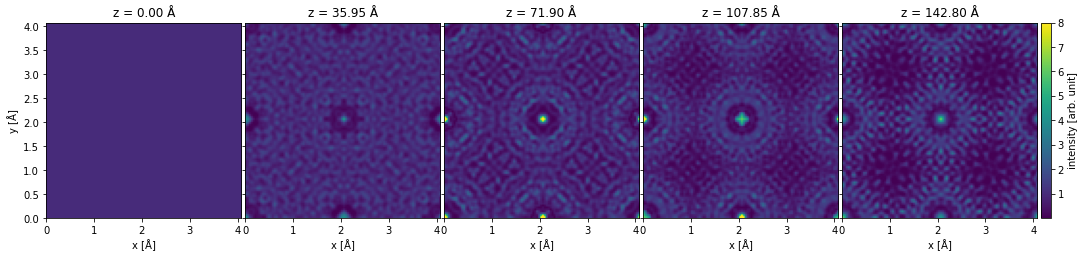

In [12]:
exit_wave_series.show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    cbar=True,
    vmax=8,
    image_grid_kwargs={"axes_pad": 0.05},
);

We can of course do the same with diffraction patterns.

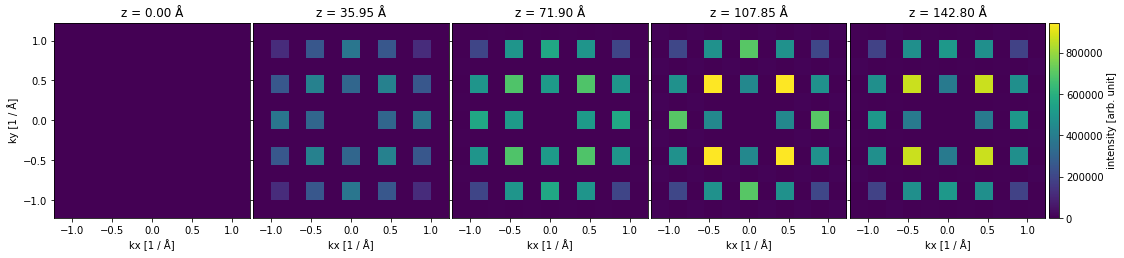

In [26]:
exit_wave_series.diffraction_patterns(block_direct=True, max_angle=30, parity="odd").show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    cbar=True,
    image_grid_kwargs={"axes_pad": 0.05},
);

## Multislice simulation with a probe
We create our initial wave function as a convergent electron beam with an energy of $200 \ \mathrm{keV}$ and a convergence semiangle of $10 \ \mathrm{mrad}$.

In [14]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=9.4, taper=1)

There are two additional considerations to take into when performing multislice simulations with probes: self-interaction errors and probe placement. 

### Self-interaction
Self-interaction errors happen when the probe overlaps with its periodic images. We see this happening below, the signs are that the probe does not have a circular symmetry, even though there are no non-symmetric aberrations. 

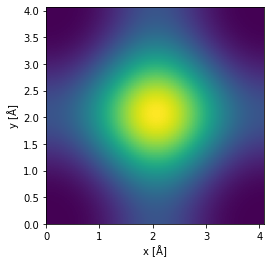

In [15]:
probe.grid.match(potential)

probe.build().show();

We get rid of self-interaction by increasing the extent of the potential until the probe intensity is sufficiently small at the boundary. Note that the potential should be large enough so there is no periodic overlap at any slice of the multislice algorithm.

The potential may be extended by modifying the atoms, however, for crystals we can also use the `CrystalPotential`. Here we repeat the potential used above by $5$ in and $x$ and $y$.

In [16]:
tiled_potential = abtem.CrystalPotential(potential, (5, 5, 1))

Now, when the probe is matched to the potential, there is no significant self-interaction.

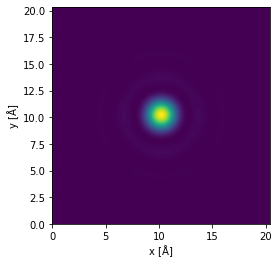

In [17]:
probe.grid.match(tiled_potential)
probe.show();

### Probe position

Above, the probe was placed (by default) at the center of the potential, later we will learn how to scan the probe for STEM simulations. Here, we manually select a few positions.

We create an array of $5$ probe positions across the center of the potential.

In [18]:
center = tiled_potential.extent[0] / 2, tiled_potential.extent[1] / 2

positions = center + np.array([np.linspace(-2.04, 2.04, 5), np.zeros(5)]).T

positions

array([[ 8.16, 10.2 ],
       [ 9.18, 10.2 ],
       [10.2 , 10.2 ],
       [11.22, 10.2 ],
       [12.24, 10.2 ]])

Running the multislice algorithm we obtain an ensemble of $5$ wave functions, one for each of the positions.

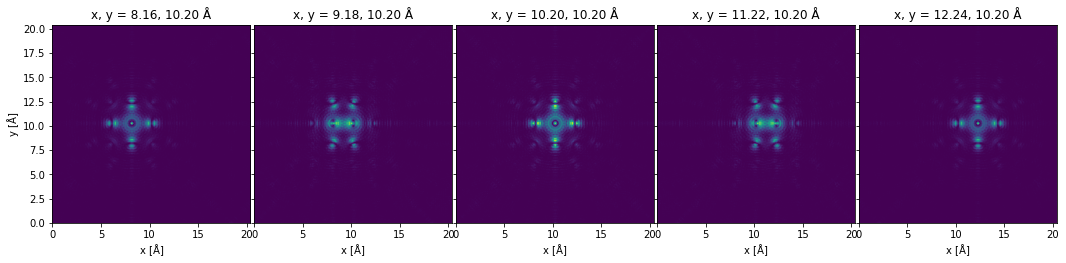

In [19]:
exit_wave_probe_positioned = probe.multislice(
    scan=positions, potential=tiled_potential
).compute()

exit_wave_probe_positioned.show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05},
);

### Convergent beam diffraction

The convergent beam (electron) diffraction (CBED) pattern may be calculated in the same manner as the SAD pattern. Here we select the third probe position from the ensemble created above and calculate its diffraction pattern.

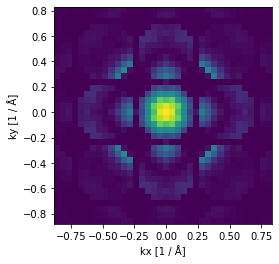

In [20]:
exit_wave_probe_positioned.diffraction_patterns(max_angle=30).show();

The diffraction pattern is rather pixelated, to improve Fourier space sampling we have repeat the potential even more. Below the potential is repeated by $15$ in $x$ and $y$, thus improving the Fourier space sampling by a factor of $3$.

In [21]:
potential_extra_tiled = abtem.CrystalPotential(potential, (15, 15, 1), exit_planes=36)

exit_wave_extra_tiled = probe.multislice(potential_extra_tiled).compute()

We show the resulting series of diffraction patterns below.

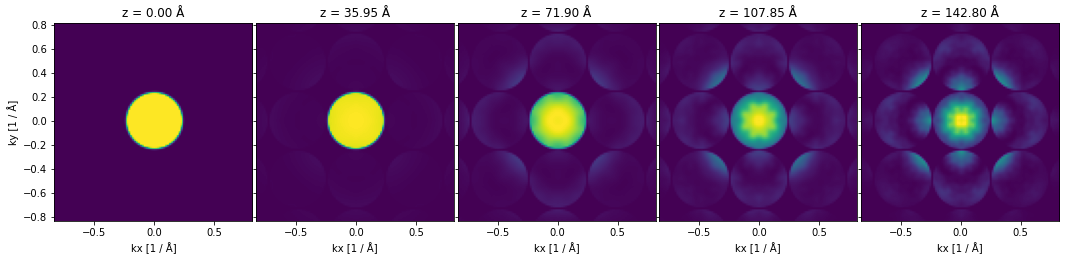

In [22]:
exit_wave_extra_tiled.diffraction_patterns(max_angle=30).show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05},
);

## Small-angle beam tilt

Small amounts of beam tilt (or equivalently sample tilt) may be included by a small modification to the propagator function

$$
    P(\vec{k}) = \exp\left[-i \pi \lambda k^2 \Delta z + 2 \pi i \Delta z (k_x \tan\theta_x + k_y \tan\theta_y)\right]
$$

where $\theta_x$, $\theta_y$ is the beam tilt in the $x$, $y$ directions. This is equivalent to shifting the wave function between slices and is only valid for very small tilts of no more than about $100 \ \mathrm{mrad}$.

```{seealso}
See our example on simulating precession electron diffraction experiments.
```

In *abTEM* beam tilt may be included using the tilt keyword of both `PlaneWave` and `Probe`. Below we create the same `Probe` used above with a series of $5$ tilts ranging from $0 \ \mathrm{mrad}$ to $8 \ \mathrm{mrad}$ along the $x$-axis.

In [23]:
tilt_x = abtem.distributions.uniform(0, 8, 5)

probe_tilt = abtem.Probe(
    energy=100e3, semiangle_cutoff=9.4, defocus=0, tilt=(tilt_x, 0.0)
)
probe_tilt.grid.match(tiled_potential)

We run the multislice algorithm with the tilted probes. The tilt is represented as an ensemble axis in the resulting exit waves.

In [24]:
exit_wave_tilt = probe_tilt.multislice(
    potential=abtem.CrystalPotential(potential, (15, 15, 1))
)

exit_wave_tilt.compute()

-------------------------------------------------

type                 label          coordinates
-------------------  -------------  -------------------
AxisAlignedTiltAxis  tilt_x [mrad]  0.00 2.00 ... 8.00
RealSpaceAxis        x [Å]          0.00 0.05 ... 61.15
RealSpaceAxis        y [Å]          0.00 0.05 ... 61.15

        bytes      shape            count     type
------  ---------  ---------------  --------  -------------
array   57.71 MiB  (5, 1230, 1230)  -         complex64
chunks  -          -                - chunks  numpy.ndarray

We plot the tilt series as an exploded plot. We see that, for thick samples, even minor tilts can have a significant effect on the resulting CBED pattern.

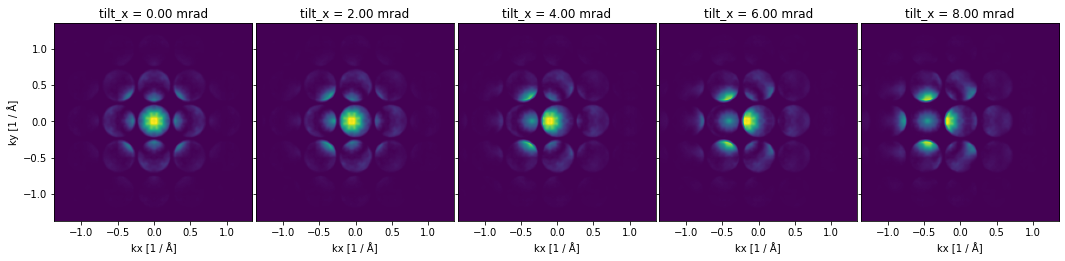

In [25]:
exit_wave_tilt.diffraction_patterns(max_angle=50).show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05},
);

```{note}
Beam tilt can also have a strong interaction with the aberrations of the electron optics, see our introduction to the contrast transfer function for details.
```